In [1]:
library(dplyr)
library(Seurat)
library(monocle3)
library("stringr")
library("factoextra")
library("Rtsne")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, 

In [2]:
disease <- read.table("/media/orsalia/SP PHD U3/ERC/lung/all_cells/LUNG.disease.limit", header=TRUE, sep=",", row.names=1)
normal <- read.table("/media/orsalia/SP PHD U3/ERC/lung/all_cells/LUNG.control.limit", header=TRUE, sep=",", row.names=1)

In [3]:
Disease <- CreateSeuratObject(counts = disease , project = "disease")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [4]:
Normal <- CreateSeuratObject(counts = normal , project = "normal")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [5]:
pbmc1 <- merge(Disease, y=Normal, add.cell.ids = c("Disease", "Normal"), project = "Diseasevsnormal",merge.data = TRUE)

In [6]:
dim(Normal)

[1] 29634  7000

In [7]:
dim(Disease)

[1] 29634  7000

In [8]:
dim(pbmc1)

[1] 29634 14000

In [9]:
GetAssayData(pbmc1)

   [[ suppressing 32 column names ‘Disease_AAACCTGAGCGACGTA_LUNG_T06’, ‘Disease_AAACCTGAGGCAAAGA_LUNG_T06’, ‘Disease_AAACCTGAGTGTTGAA_LUNG_T06’ ... ]]

   [[ suppressing 32 column names ‘Disease_AAACCTGAGCGACGTA_LUNG_T06’, ‘Disease_AAACCTGAGGCAAAGA_LUNG_T06’, ‘Disease_AAACCTGAGTGTTGAA_LUNG_T06’ ... ]]

   [[ suppressing 32 column names ‘Disease_AAACCTGAGCGACGTA_LUNG_T06’, ‘Disease_AAACCTGAGGCAAAGA_LUNG_T06’, ‘Disease_AAACCTGAGTGTTGAA_LUNG_T06’ ... ]]



29634 x 14000 sparse Matrix of class "dgCMatrix"
                                                                                             
A1BG                . 1  . . .  .  . .  . . .  1 . .  .  . . . . . . . .  .  . .  . .  .  . .
A1BG-AS1            . .  . . .  .  . .  . . .  . . .  .  . . . . . . . .  .  . .  . .  .  . .
A1CF                . .  . . .  .  . .  . . .  . . .  .  . . . . . . . .  .  . .  . .  .  . .
A2M                 . .  . 2 .  . 36 .  . . .  1 . .  .  7 . . . . . . .  .  1 .  . 1  .  3 .
A2M-AS1             . .  . . .  .  . .  . . .  . . .  .  . . . . . . . .  .  . .  . .  .  . .
A2ML1               . .  . . .  .  . .  . . .  . . .  .  . . . . . . . .  .  . .  . .  .  . .
A2ML1-AS1           . .  . . .  .  . .  . . .  . . .  .  . . . . . . . .  .  . .  . .  .  . .
A2ML1-AS2           . .  . . .  .  . .  . . .  . . .  .  . . . . . . . .  .  . .  . .  .  . .
A4GALT              . .  . . .  .  . .  . . .  . . .  .  . . . . . . . .  .  . .  . .  .  . .
A4GNT      

In [10]:
pbmcF <- CreateSeuratObject(counts=GetAssayData(pbmc1), project = "Diseasevsnormal", min.cells = 3, min.features = 200)

In [11]:
pbmcF[["percent.mt"]] <- PercentageFeatureSet(object = pbmcF, pattern = "^MT-")
VlnPlot(object = pbmcF, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
plot1 <- FeatureScatter(object = pbmcF, feature1 = "nCount_RNA", feature2 = "percent.mt") 
plot2 <- FeatureScatter(object = pbmcF, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") 
CombinePlots(plots = list(plot1,plot2))
#pbmcF <- subset(x = pbmcF, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


In [12]:
pbmcF <- NormalizeData(object = pbmcF, normalization.method = "LogNormalize", scale.factor = 1e4)
#pbmc <- NormalizeData(object = pbmc)

In [13]:
levels(pbmcF)

[1] "Disease" "Normal"

In [14]:
pbmcF <- FindVariableFeatures(object = pbmcF,selection.method = 'vst', nfeatures = 2000)
top10 <- head(x = VariableFeatures(object = pbmcF), 10)
plot1 <- VariableFeaturePlot(object = pbmcF)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)


When using repel, set xnudge and ynudge to 0 for optimal results



Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”
Regressing out percent.mt

Centering and scaling data matrix



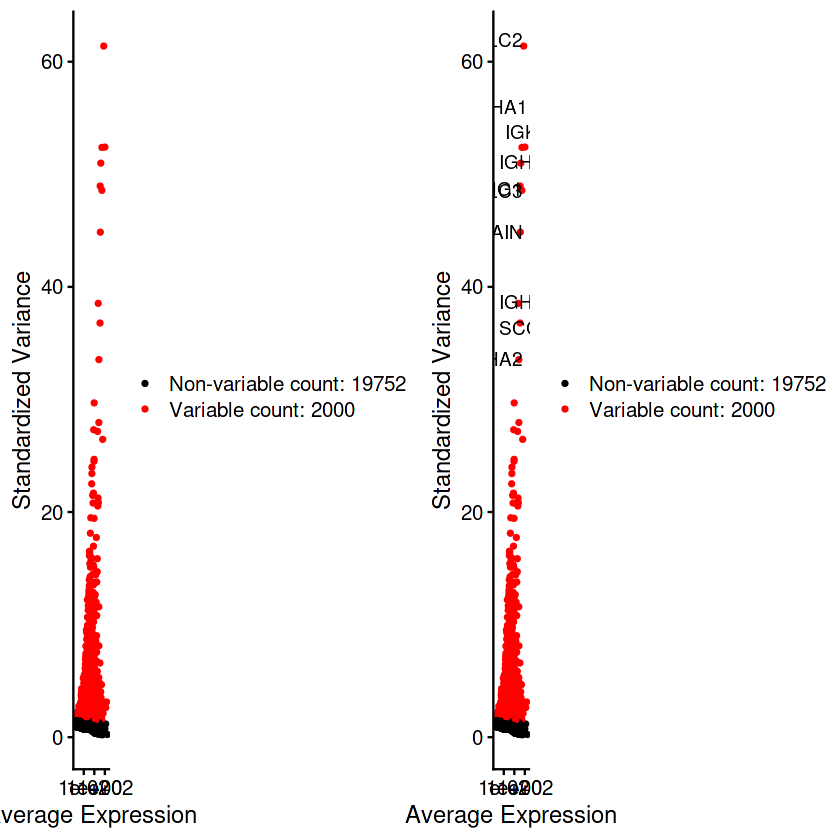

In [15]:
CombinePlots(plots = list(plot1, plot2))
all.genes <- rownames(x = pbmcF)
#pbmcF <- ScaleData(object = pbmcF, features = all.genes)
#pbmcF <- ScaleData(object = pbmcF)
pbmcF <- ScaleData(object = pbmcF, vars.to.regress = 'percent.mt')


In [16]:
levels(pbmcF)

[1] "Disease" "Normal"

In [17]:
monocyte.de.markers <- FindMarkers(pbmcF, ident.1 = "Normal", ident.2 = "Disease")
# view results
head(monocyte.de.markers)

p_val avg_log2FC pct.1 pct.2 p_val_adj
ACOT7    0     0.5417388  0.308 0.058 0        
ACP5     0     1.3469467  0.470 0.211 0        
ADAMTSL4 0     0.3858800  0.268 0.038 0        
AIF1     0     1.2891961  0.513 0.198 0        
ALDH2    0     1.6543255  0.493 0.216 0        
ALOX5    0     0.7542790  0.377 0.111 0

In [120]:
#write.csv(monocyte.de.markers, file = "/media/orsalia/SP PHD U3/ERC/lung/all_cells/normvsdiseaseall_lungcluster14.csv")

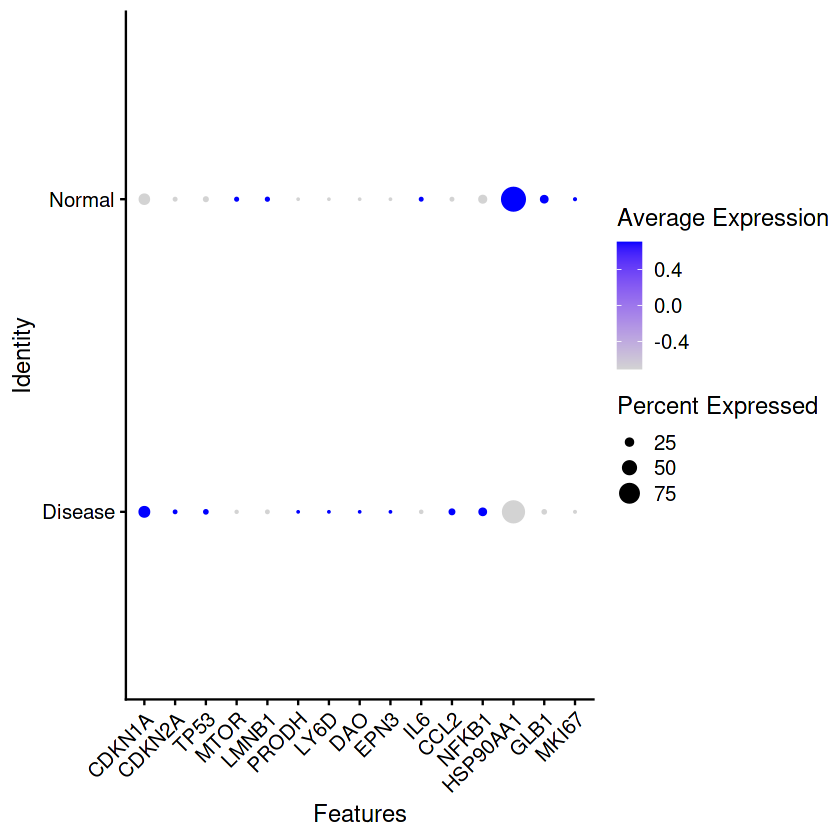

In [18]:
features <- c("CDKN1A", "CDKN2A", "TP53", "MTOR","LMNB1","PRODH","LY6D","DAO","EPN3","IL6", "CCL2","NFKB1", "HSP90AA1","GLB1","MKI67")
DotPlot(pbmcF, features = features) + RotatedAxis()
#features <- c("CSPG2","PLXDC2","EST","WNT5A","DOC1","FBOX32","OLFML2A","IGF2","MXRA5","COL1A1","MMP2","RKHD3","CKTSF1B1")
#DotPlot(pbmcF, features = features) + RotatedAxis()
#features <- c("MFAP2","CXCL14","P311","DAO","PTCHD4","FILIP1L","PDL1M1","LRP10","TMEM30A","ARRDC4","CCND3","CHPF2","TAP1","SLC9A7","PURPL","ELMOD1","TGFB1","MAPK14","IL1b","IGFBP4","IGFBP6","IGFBP1","CNTF","JUND","ERK1","JNK")
#DotPlot(pbmcF, features = features) + RotatedAxis()

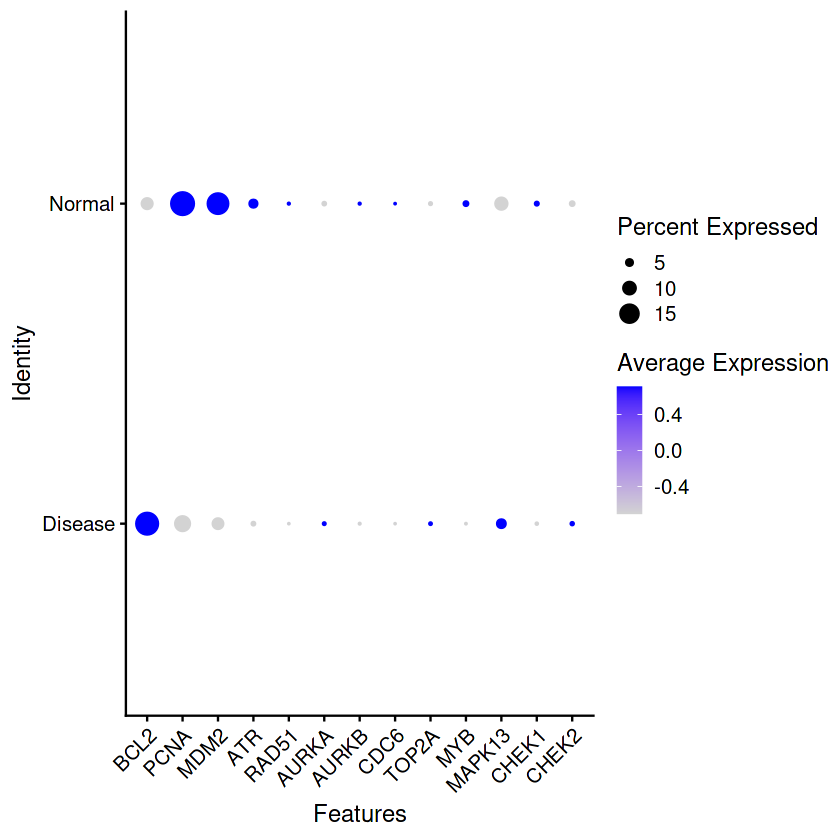

In [19]:
features <- c("BCL2","PCNA","MDM2","ATR","RAD51","AURKA","AURKB","CDC6","TOP2A","MYB","MAPK13","CHEK1", "CHEK2")
DotPlot(pbmcF, features = features) + RotatedAxis()

In [ ]:
pbmcF$groups <- sample(c("Normal", "Disease"), size = ncol(pbmcF), replace = TRUE)
features <- c("BCL2","PCNA","MDM2","ATR","RAD51")
VlnPlot(pbmcF, features = features)
features <- c("AURKA","AURKB","CDC60","TOP2A","MYB")
VlnPlot(pbmcF, features = features)
features <- c("TIMP1","TOMP2","MAPK13","CCNA2")
VlnPlot(pbmcF, features = features)
features <- c("CCNB1", "CDC20", "CHEK1", "CHEK2")
VlnPlot(pbmcF, features = features)
features <- c("CENPE", "CTPS")
VlnPlot(pbmcF, features = features)
features <- c("CSPG2","PLXDC2","EST","WNT5A","DOC1")
VlnPlot(pbmcF, features = features)
features <- c("FBOX32","OLFML2A","IGF2","MXRA5","COL1A1")
VlnPlot(pbmcF, features = features)
features <- c("MMP2","RKHD3","CKTSF1B1","MFAP2","CXCL14")
VlnPlot(pbmcF, features = features)
features <- c("P311","DAO","PTCHD4","FILIP1L","PDL1M1")
VlnPlot(pbmcF, features = features)
features <- c("LRP10","TMEM30A","ARRDC4","CCND3","CHPF2")
VlnPlot(pbmcF, features = features)
features <- c("TAP1","SLC9A7","PURPL","ELMOD1","TGFB1")
VlnPlot(pbmcF, features = features)
features <- c("MAPK14","IL1b","IGFBP4","IGFBP6")
VlnPlot(pbmcF, features = features)
features <- c("IGFBP1","CNTF","JUND","NFKB1","ERK1","JNK","JUND")
VlnPlot(pbmcF, features = features)


In [ ]:
features <- c("BCL2","PCNA","MDM2","ATR","RAD51","AURKA","AURKB","CDC6","TOP2A","MYB","TIMP1","TOMP2","MAPK13","CCNA2","CCNB1","CDC20","CHEK1","CHEK2","CENPE","CTPS")
DotPlot(pbmcF, features = features) + RotatedAxis()

In [ ]:
pbmcF$groups <- sample(c("Normal", "Disease"), size = ncol(pbmcF), replace = TRUE)
features <- c("BCL2","PCNA","MDM2","ATR","RAD51","AURKA")
VlnPlot(pbmcF, features = features)
features <- c("AURKB","CDC6","TOP2A","MYB","TIMP1","TIMP2")
VlnPlot(pbmcF, features = features)
features <- c("MAPK13","CCNA2","CCNB1", "CDC20", "CHEK1", "CHEK2")
VlnPlot(pbmcF, features = features)
features <- c("CENPE", "CTPS")
VlnPlot(pbmcF, features = features)
features <- c("CSPG2","PLXDC2","EST","WNT5A","DOC1")
VlnPlot(pbmcF, features = features)
features <- c("FBOX32","OLFML2A","IGF2","MXRA5","COL1A1")
VlnPlot(pbmcF, features = features)
features <- c("MMP2","RKHD3","CKTSF1B1","MFAP2","CXCL14")
VlnPlot(pbmcF, features = features)
features <- c("P311","DAO","PTCHD4","FILIP1L","PDL1M1")
VlnPlot(pbmcF, features = features)
features <- c("LRP10","TMEM30A","ARRDC4","CCND3","CHPF2")
VlnPlot(pbmcF, features = features)
features <- c("TAP1","SLC9A7","PURPL","ELMOD1","TGFB1")
VlnPlot(pbmcF, features = features)
features <- c("MAPK14","IL1b","IGFBP4","IGFBP6")
VlnPlot(pbmcF, features = features)
features <- c("IGFBP1","CNTF","JUND","NFKB1","ERK1","JNK","JUND")
VlnPlot(pbmcF, features = features)

In [ ]:
write.csv(monocyte.de.markers, file = "/media/orsalia/SP PHD U3/ERC/lung/all_cells/normvsdiseaseall_lungTcells.csv")

PC_ 1 
Positive:  IGFBP7, RARRES2, C1R, C1S, CALD1, CNN3, NFIB, CYR61, DCN, COL1A2 
	   MGP, TMEM98, MFAP4, LUM, BGN, SOD3, NBL1, CCDC80, FBLN1, SPARCL1 
	   MMP2, CTGF, NNMT, COL6A2, MXRA8, COL6A1, PCOLCE, AEBP1, SEPP1, CFH 
Negative:  CD52, S100A4, ALOX5AP, HLA-DPB1, TYROBP, C1orf162, FCER1G, HLA-DPA1, FCGR3A, LST1 
	   LTB, HLA-DQB1, RGS1, AIF1, HLA-DQA1, SPI1, CCL4, MS4A7, HLA-DRA, SNX10 
	   NKG7, BCL2A1, CD74, LYZ, HLA-DRB1, C1QA, MNDA, CYBB, LY86, MSR1 
PC_ 2 
Positive:  LTB, SMIM22, ELF3, TRBC1, OCIAD2, AGR3, TSPAN1, C20orf85, HOPX, FXYD3 
	   CLDN3, C12orf75, SLC44A4, C1orf194, CAPS, RSPH1, LRRIQ1, C9orf24, FAM183A, C5orf49 
	   RGS1, MS4A8, SNTN, CLDN4, KLRB1, AGR2, TMC5, DNAH12, PIFO, IGKC 
Negative:  FTL, CD68, ALDH2, GRN, FN1, C1QC, SERPING1, MSR1, CST3, C1QB 
	   MARCO, C1QA, MCEMP1, MS4A7, SPI1, PLBD1, MRC1, APOC1, CSTA, LGALS3 
	   FCGRT, TREM1, FTH1, INHBA, GPNMB, AIF1, VSIG4, FBP1, CXCL16, CTSB 
PC_ 3 
Positive:  DCN, LUM, COL1A2, BGN, MFAP4, C1S, NBL1, CALD1, MMP2, F

PC_ 1 
Positive:  IGFBP7, RARRES2, C1R, C1S, CALD1 
Negative:  CD52, S100A4, ALOX5AP, HLA-DPB1, TYROBP 
PC_ 2 
Positive:  LTB, SMIM22, ELF3, TRBC1, OCIAD2 
Negative:  FTL, CD68, ALDH2, GRN, FN1 
PC_ 3 
Positive:  DCN, LUM, COL1A2, BGN, MFAP4 
Negative:  C9orf24, C20orf85, RSPH1, C1orf194, CAPS 
PC_ 4 
Positive:  C20orf85, C9orf24, C1orf194, FAM183A, SNTN 
Negative:  SFTA2, NAPSA, S100A14, SFTPD, SFTPB 
PC_ 5 
Positive:  FABP4, CD52, MCEMP1, PCOLCE2, INHBA 
Negative:  IER3, IL1B, FGL2, FAM26F, MARCKS 


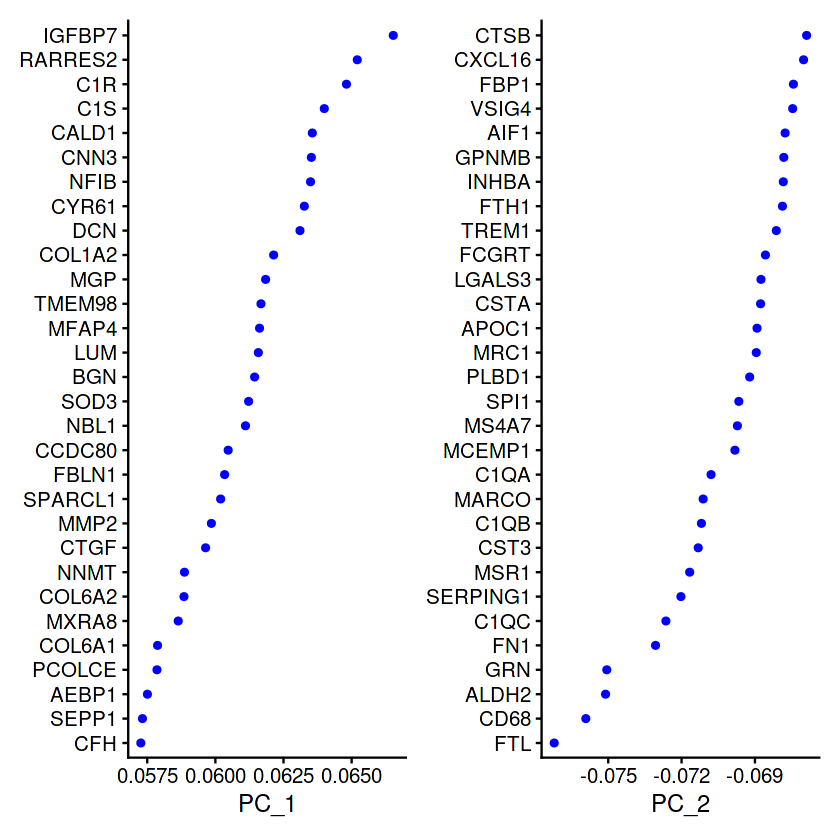

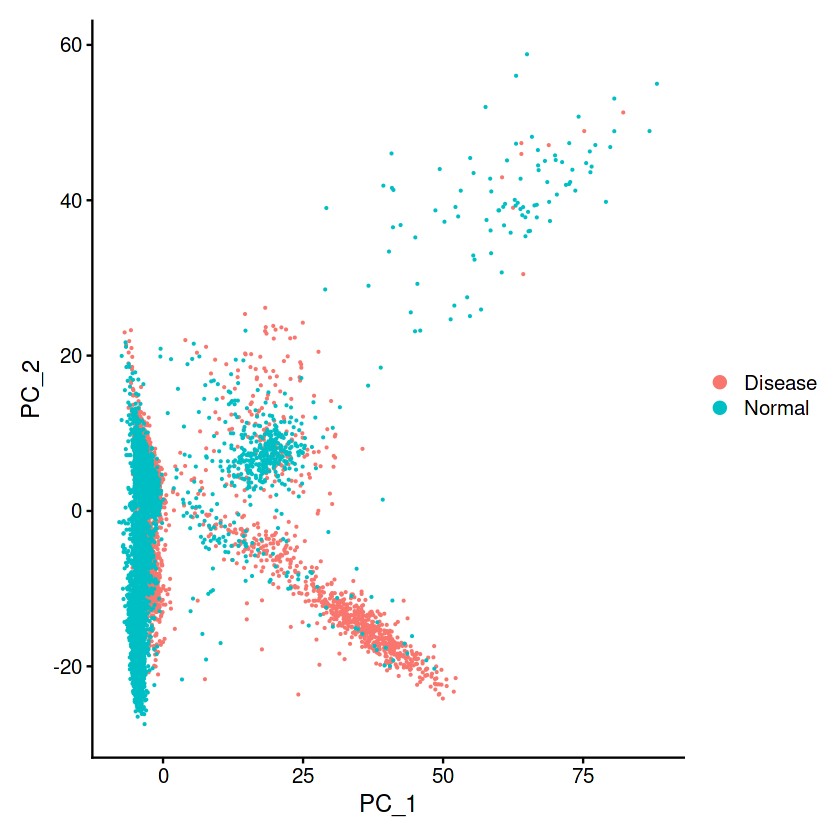

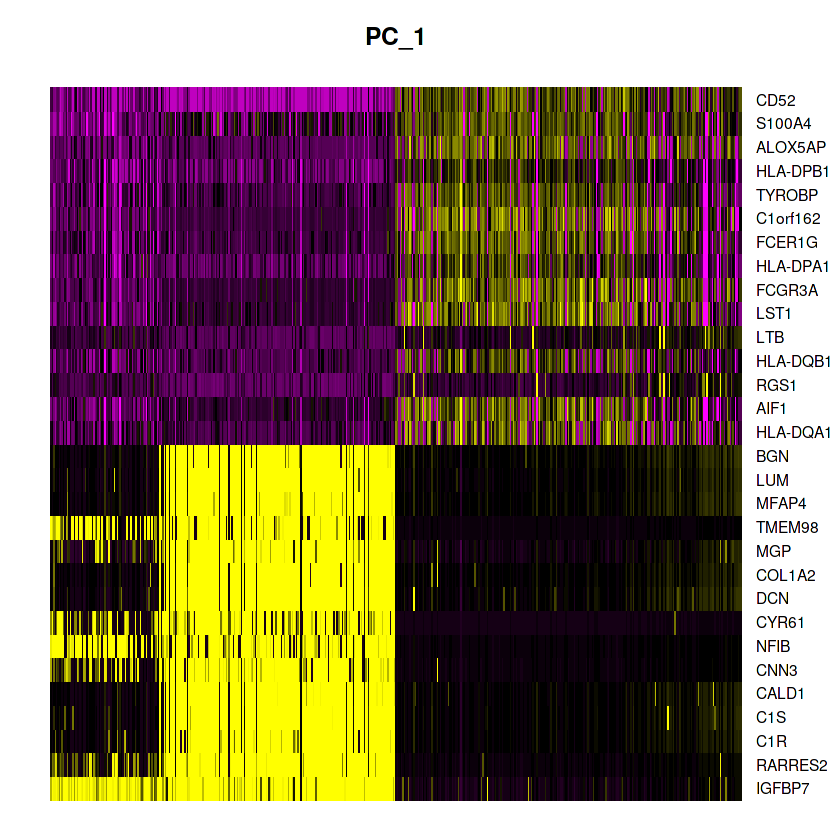

In [20]:
pbmcF <- RunPCA(object = pbmcF, features = VariableFeatures(object = pbmcF))
print(x = pbmcF[['pca']], dims = 1:5, nfeatures = 5)
VizDimLoadings(object = pbmcF, dims = 1:2, reduction = 'pca')
DimPlot(object = pbmcF, reduction = 'pca')
DimHeatmap(object = pbmcF, dims = 1, cells = 500, balanced = TRUE)

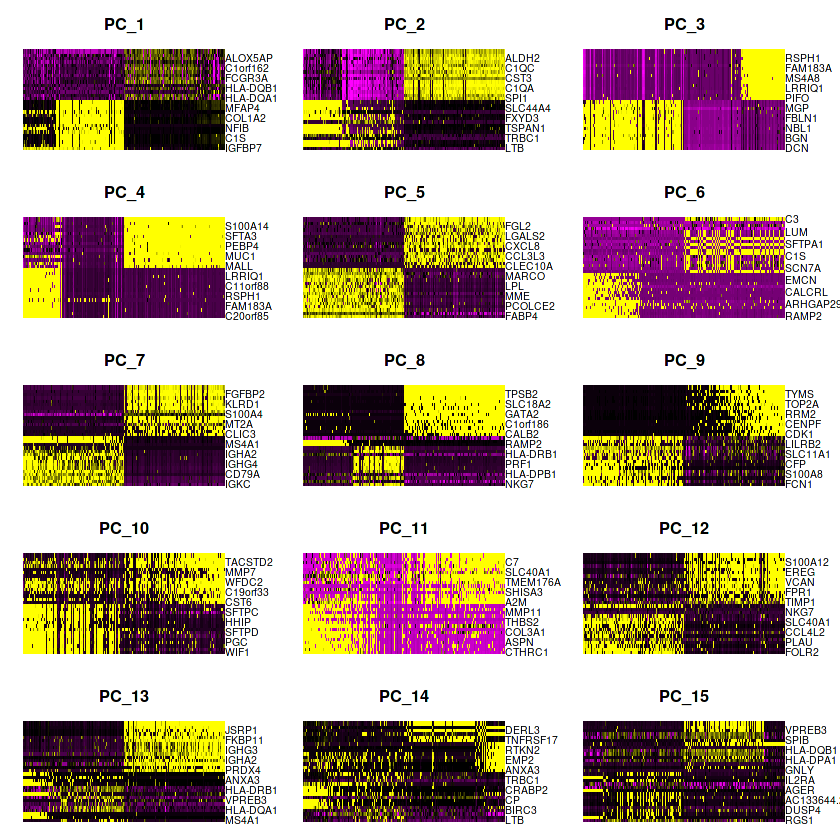

In [21]:
DimHeatmap(object = pbmcF, dims = 1:15, cells = 500, balanced = TRUE)

In [288]:
pbmcF <- FindNeighbors(object = pbmcF, dims = 1:10)
pbmcF <- FindClusters(object = pbmcF, resolution = 0.5)
head(x = Idents(object = pbmcF), 5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 459
Number of edges: 16661

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7181
Number of communities: 3
Elapsed time: 0 seconds


Disease_AAAGATGAGCGATAGC_LUNG_T06 Disease_AAAGATGGTACGACCC_LUNG_T06 
                                2                                 2 
Disease_AACTCTTAGGCATTGG_LUNG_T06 Disease_ACAGCTAAGACAAGCC_LUNG_T06 
                                2                                 1 
Disease_ACATACGTCTTTAGGG_LUNG_T06 
                                2 
Levels: 0 1 2

In [24]:
pbmcF <- RunUMAP(object = pbmcF, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
22:54:29 UMAP embedding parameters a = 0.9922 b = 1.112

22:54:29 Read 14000 rows and found 10 numeric columns

22:54:29 Using Annoy for neighbor search, n_neighbors = 30

22:54:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:54:31 Writing NN index file to temp file /tmp/RtmpwNGSHG/filed56e4a21ba8e

22:54:31 Searching Annoy index using 1 thread, search_k = 3000

22:54:36 Annoy recall = 100%

22:54:37 Commencing smooth kNN distance calibration using 1 thread

22:54:38 Initializing fr

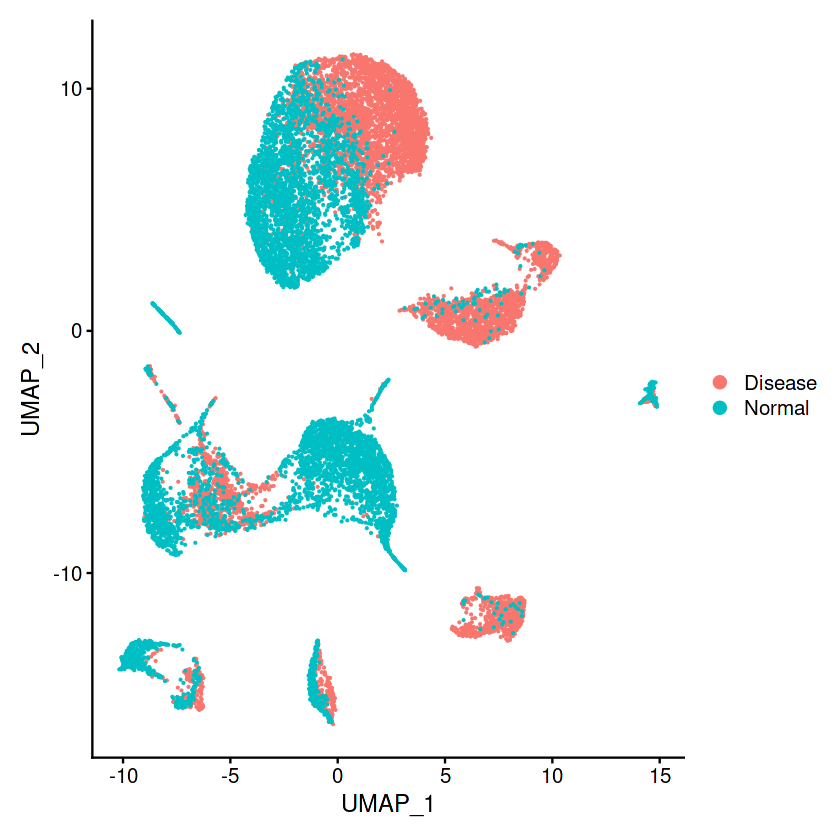

In [25]:
DimPlot(object = pbmcF, reduction = 'umap')

In [26]:
pbmc.markers <- FindAllMarkers(object = pbmcF, only.pos = TRUE, min.pct = 0.25,logfc.threshold = 0.17)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_log2FC)
write.csv(pbmc.markers, file = "/media/orsalia/SP PHD U3/ERC/lung/all_cells/normandanddiseaseallmarkerslungTcells.csv")

Calculating cluster Disease

Calculating cluster Normal



p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene 
1 0     4.251964   0.868 0.268 0         Disease IGKC 
2 0     4.076148   0.686 0.114 0         Disease IGHA1
3 0     3.493050   0.538 0.009 0         Normal  FABP4
4 0     3.191775   0.869 0.434 0         Normal  SFTPC

In [27]:
head(pbmcF@meta.data)
write.csv(pbmcF@meta.data, "/media/orsalia/SP PHD U3/ERC/lung/all_cells/object_clusterslungnormvscancer.csv")

orig.ident nCount_RNA nFeature_RNA percent.mt
Disease_AAACCTGAGCGACGTA_LUNG_T06 Disease    2859        864         2.868136  
Disease_AAACCTGAGGCAAAGA_LUNG_T06 Disease    3323       1113         3.912128  
Disease_AAACCTGAGTGTTGAA_LUNG_T06 Disease    3958       1019         3.309752  
Disease_AAACCTGAGTTGCAGG_LUNG_T06 Disease    1695        711         9.498525  
Disease_AAACCTGCAATCACAC_LUNG_T06 Disease    3301       1060         2.453802  
Disease_AAACCTGCAATCAGAA_LUNG_T06 Disease    3805       1277         4.047306

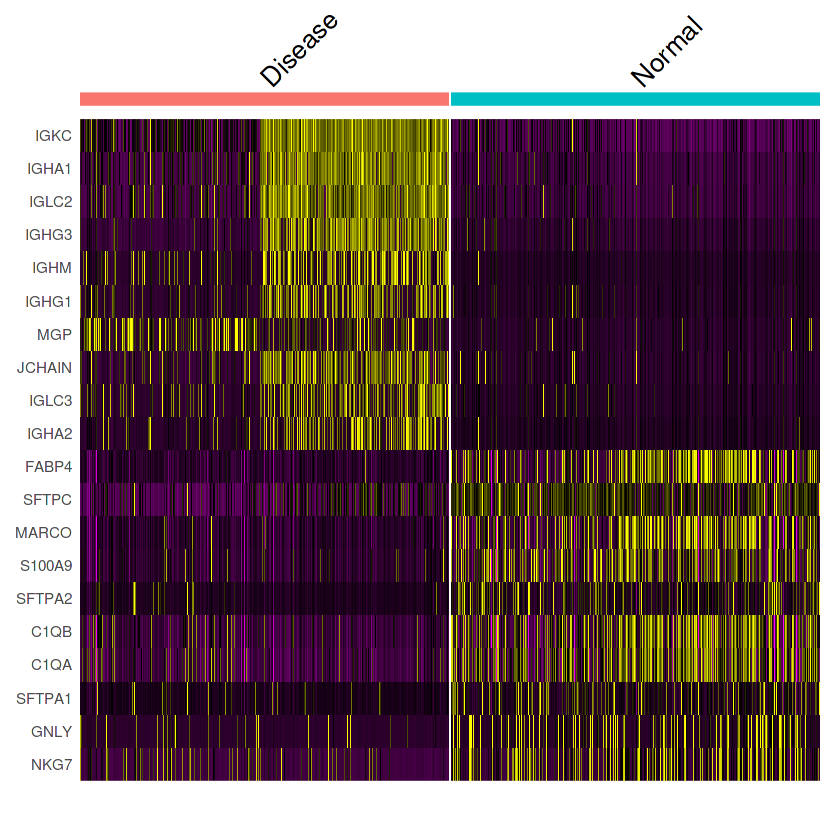

In [28]:
pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(object = pbmcF, features = top10$gene) + NoLegend()


Warning message in FetchData(object = object, vars = features, slot = slot):
“The following requested variables were not found: ΜKI67”


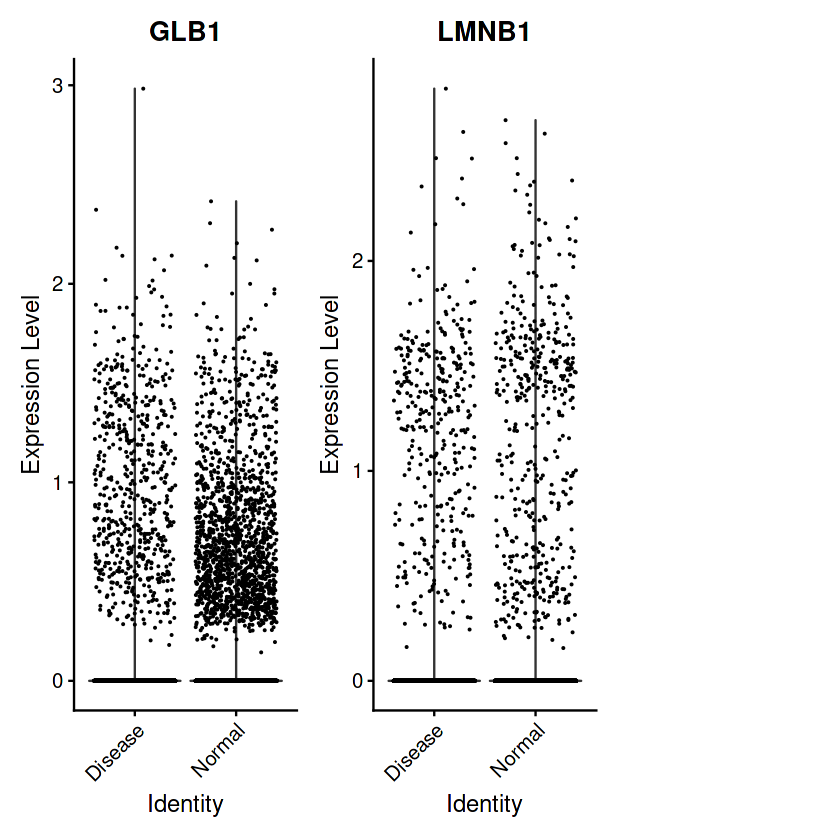

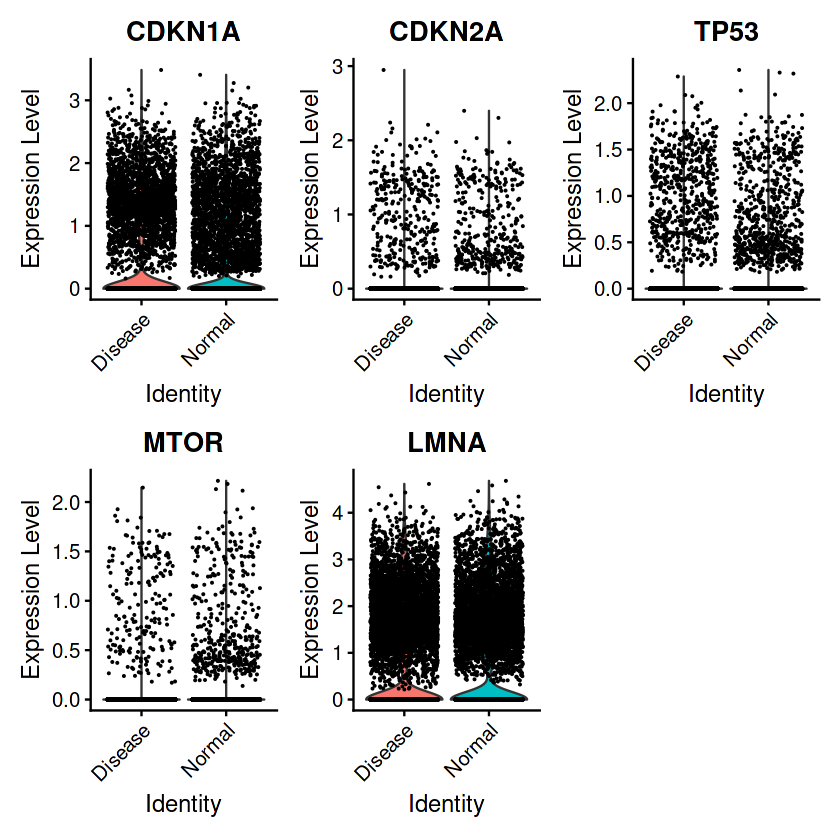

Warning message in FetchData(object = object, vars = features, slot = slot):
“The following requested variables were not found: IL8”


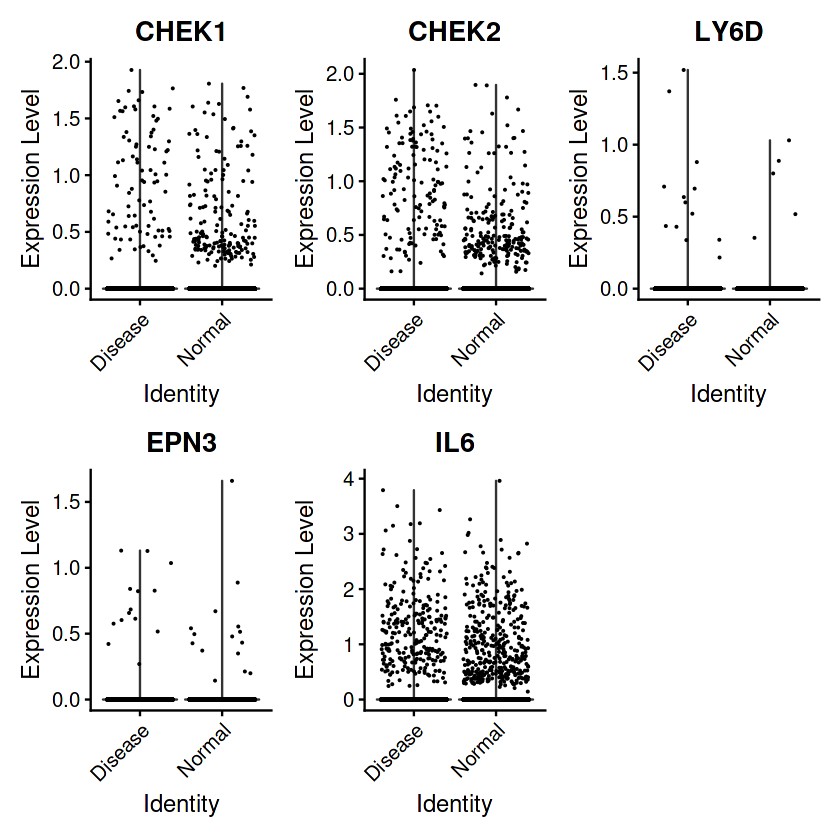

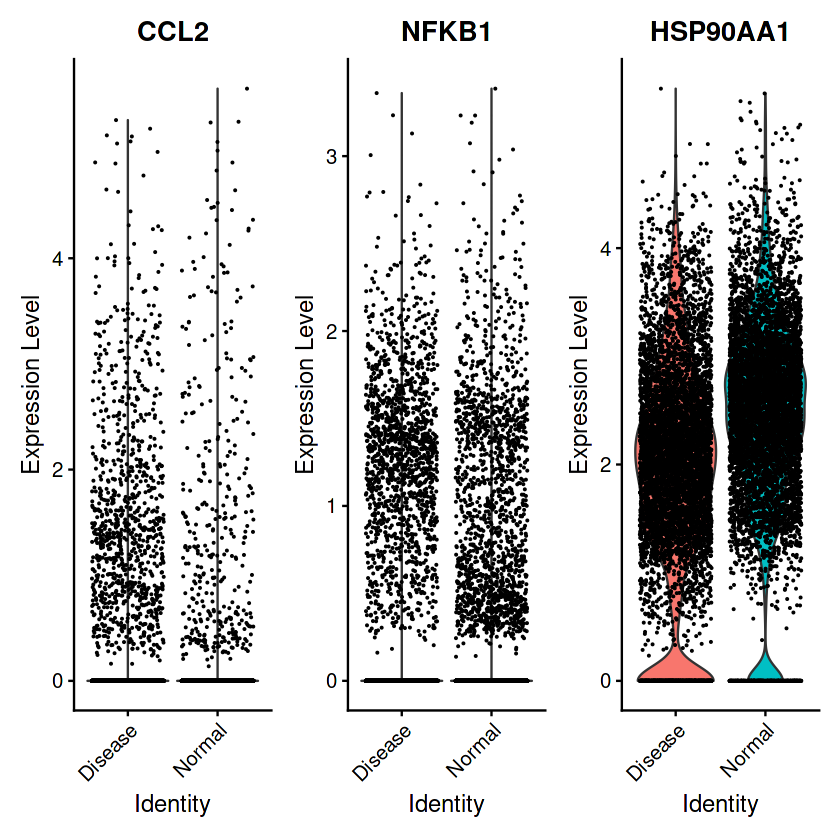

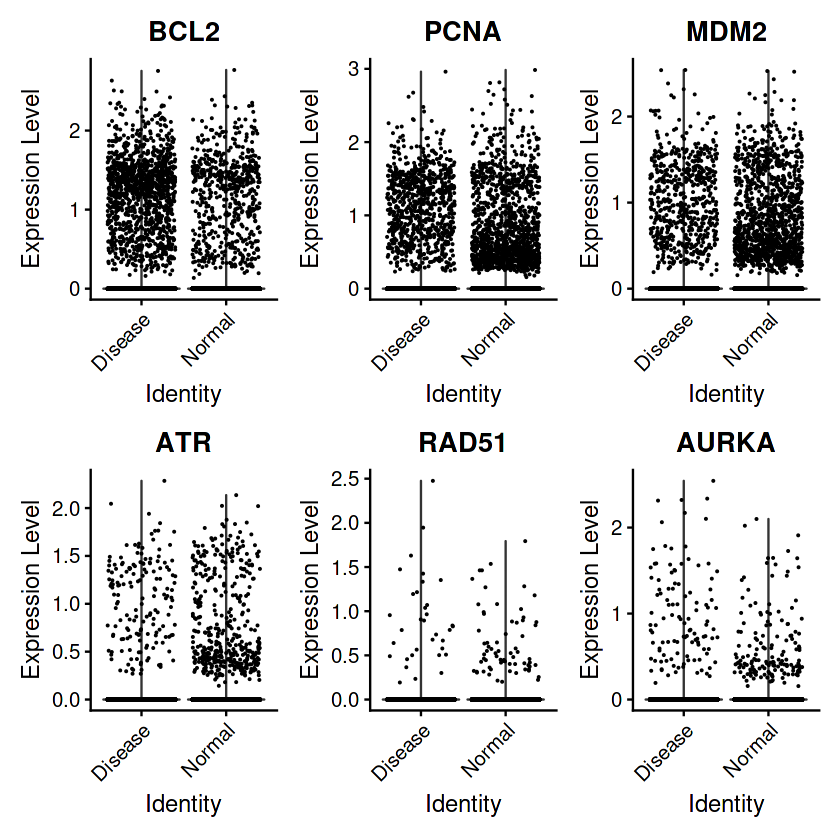

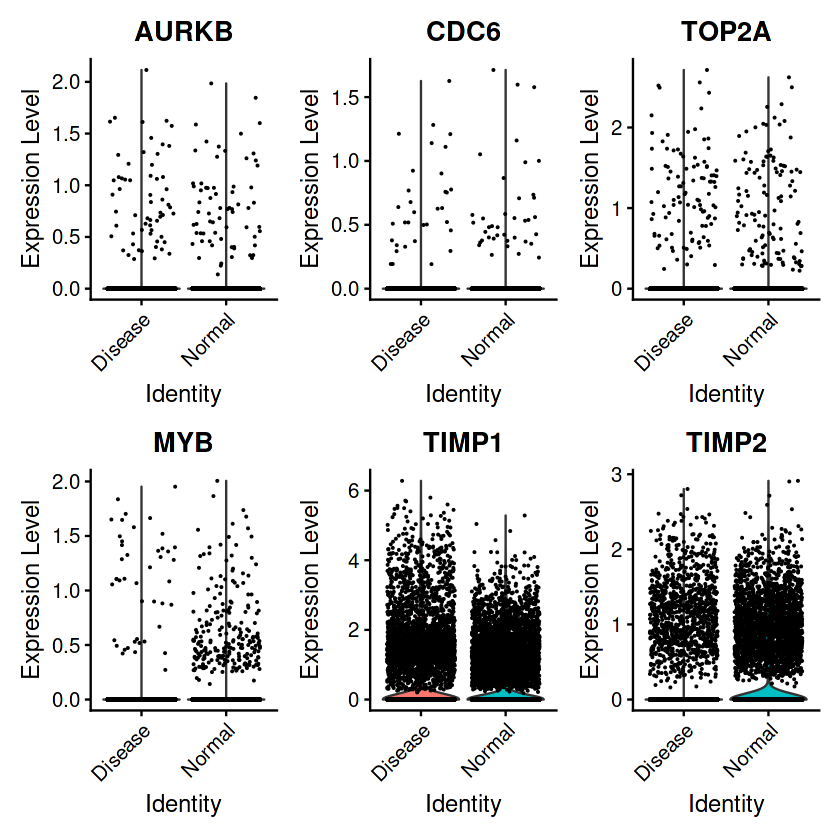

Warning message in FetchData(object = object, vars = features, slot = slot):
“The following requested variables were not found: CTPS”


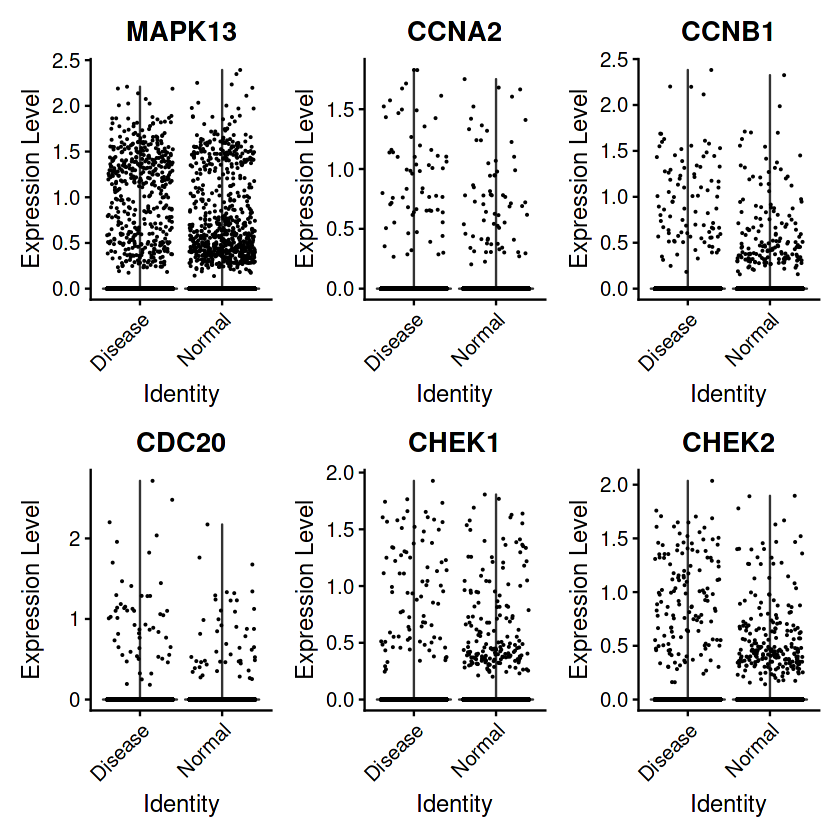

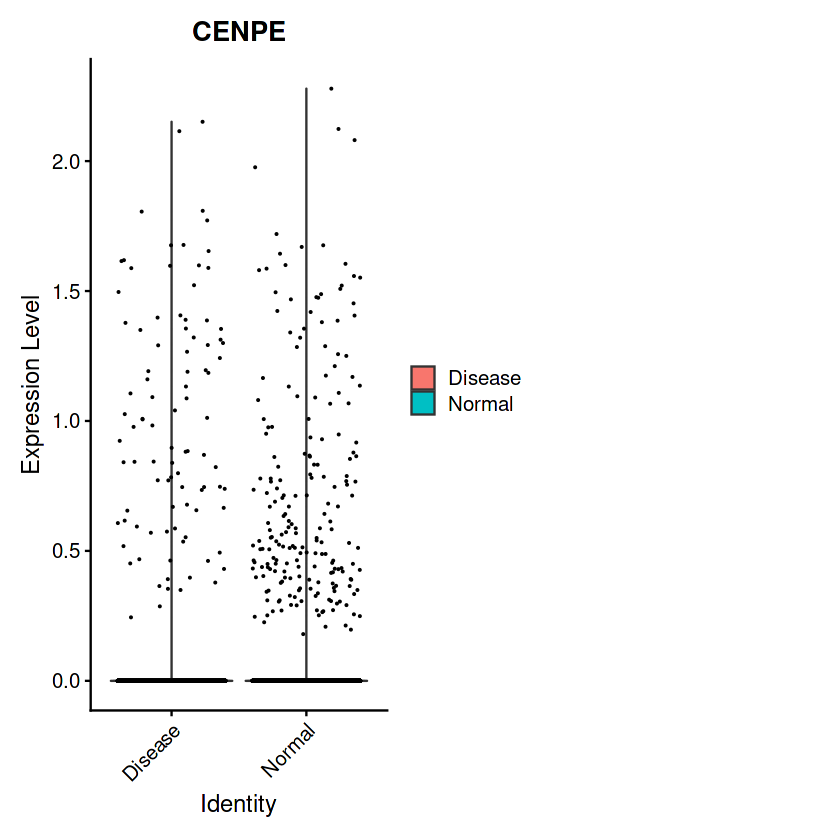

In [22]:
VlnPlot(object = pbmcF, features = c("ΜKI67", "GLB1","LMNB1"))

VlnPlot(object = pbmcF, features = c("CDKN1A", "CDKN2A", "TP53", "MTOR","LMNA"))
VlnPlot(object = pbmcF, features = c("CHEK1","CHEK2","LY6D","EPN3","IL6"))
VlnPlot(object = pbmcF, features = c("IL8", "CCL2","NFKB1", "HSP90AA1"))

VlnPlot(object = pbmcF, features = c("BCL2","PCNA","MDM2","ATR","RAD51","AURKA"))
VlnPlot(object = pbmcF, features = c("AURKB","CDC6","TOP2A","MYB","TIMP1","TIMP2"))
VlnPlot(object = pbmcF, features = c("MAPK13","CCNA2","CCNB1", "CDC20", "CHEK1", "CHEK2"))
VlnPlot(object = pbmcF, features = c("CENPE", "CTPS"))


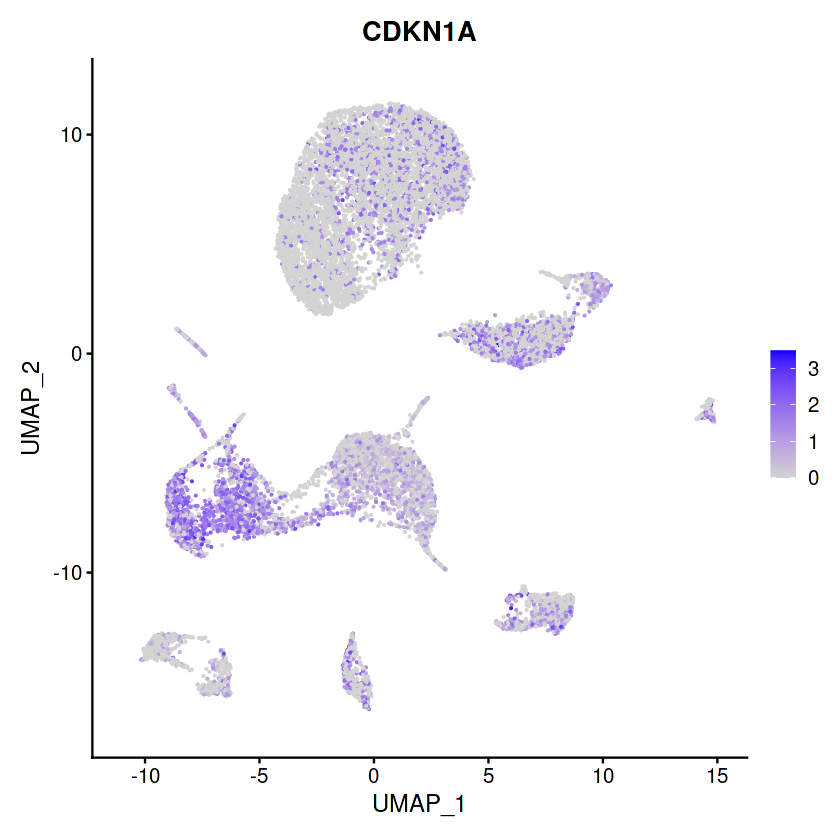

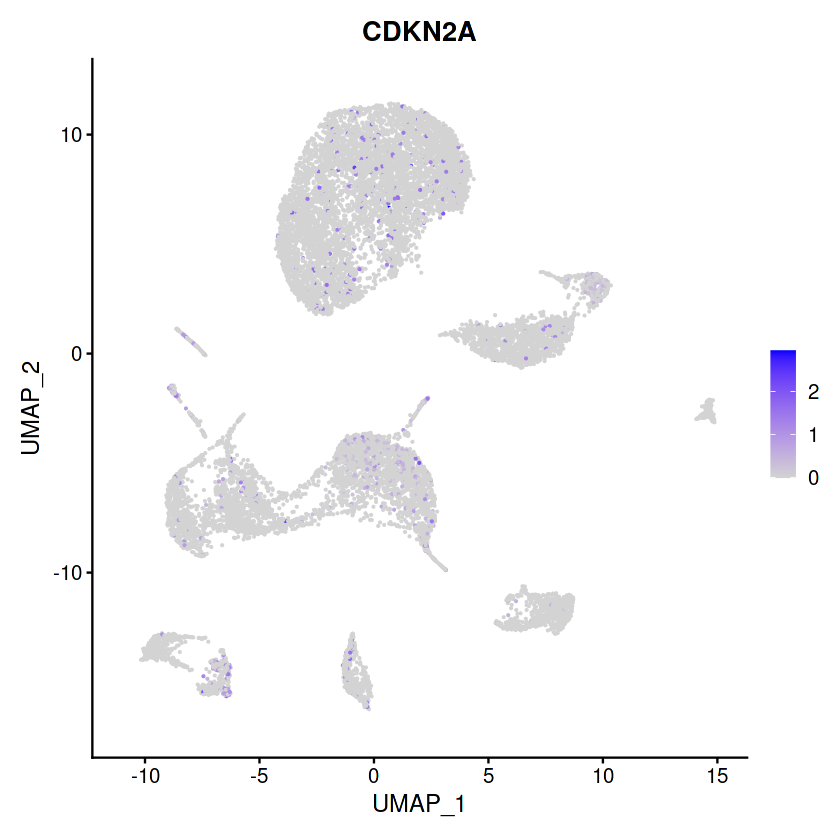

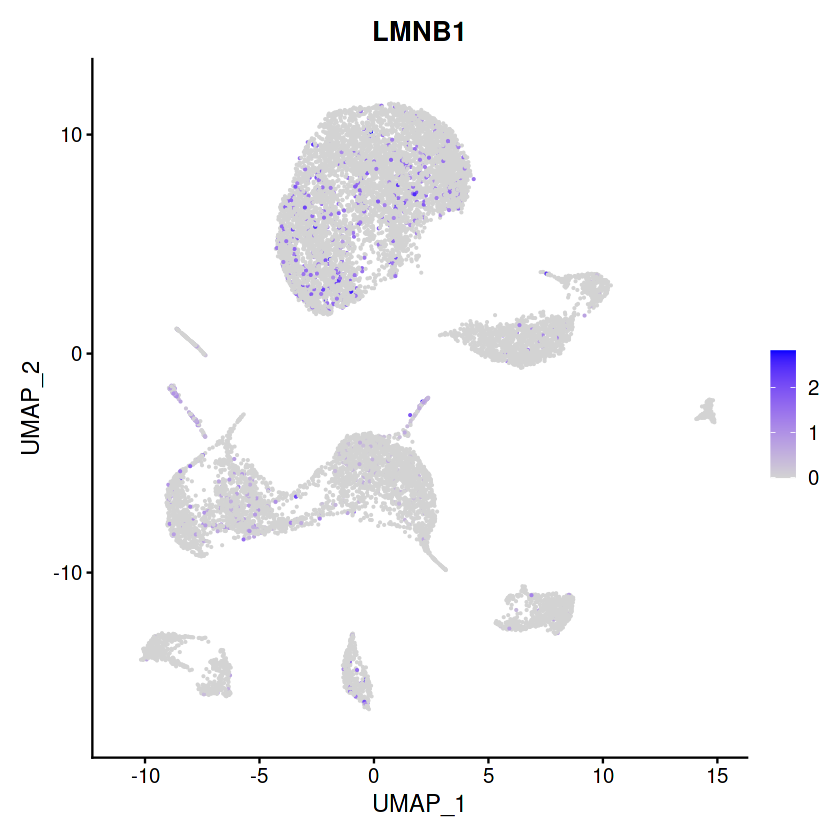

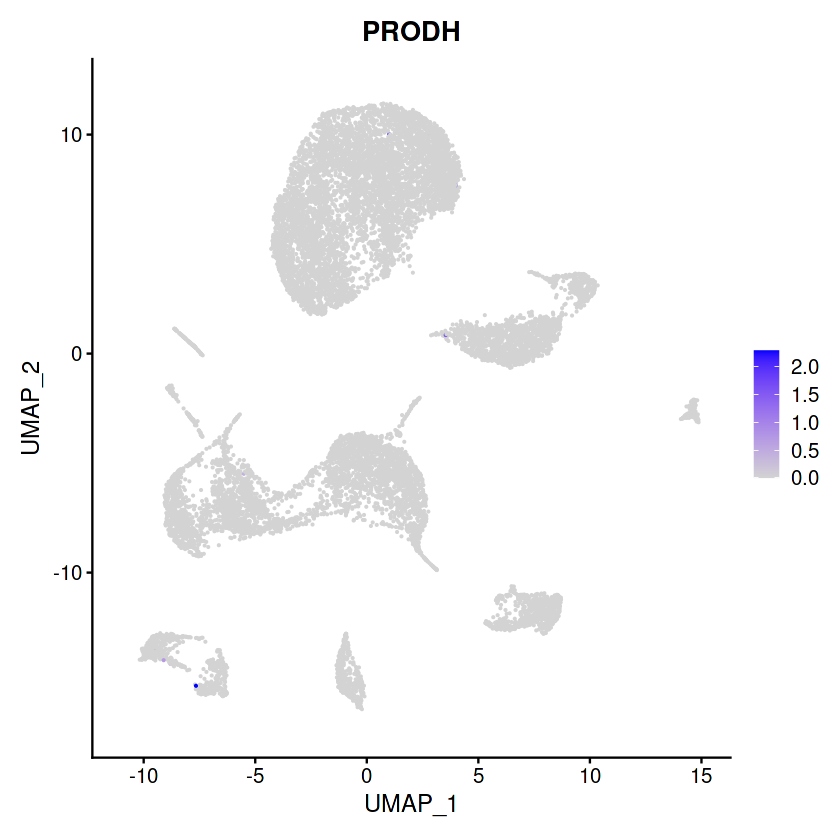

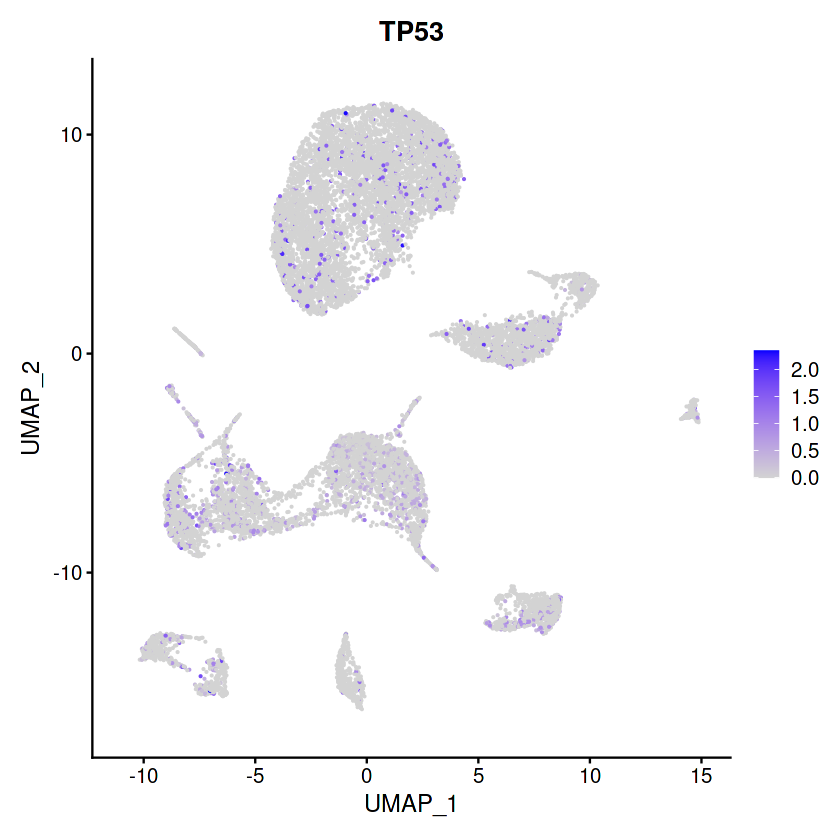

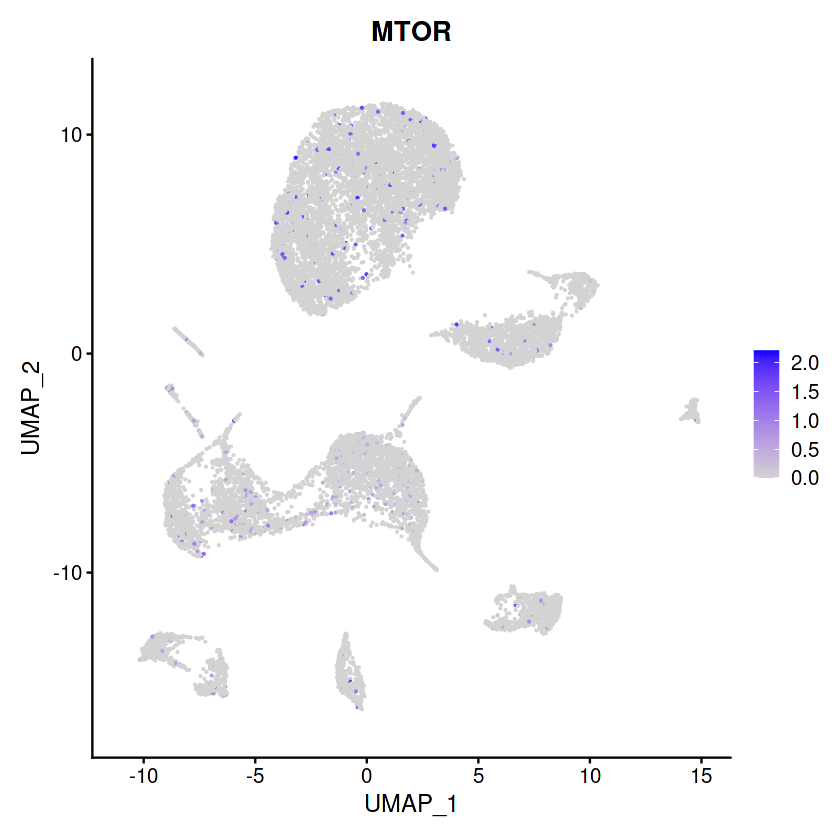

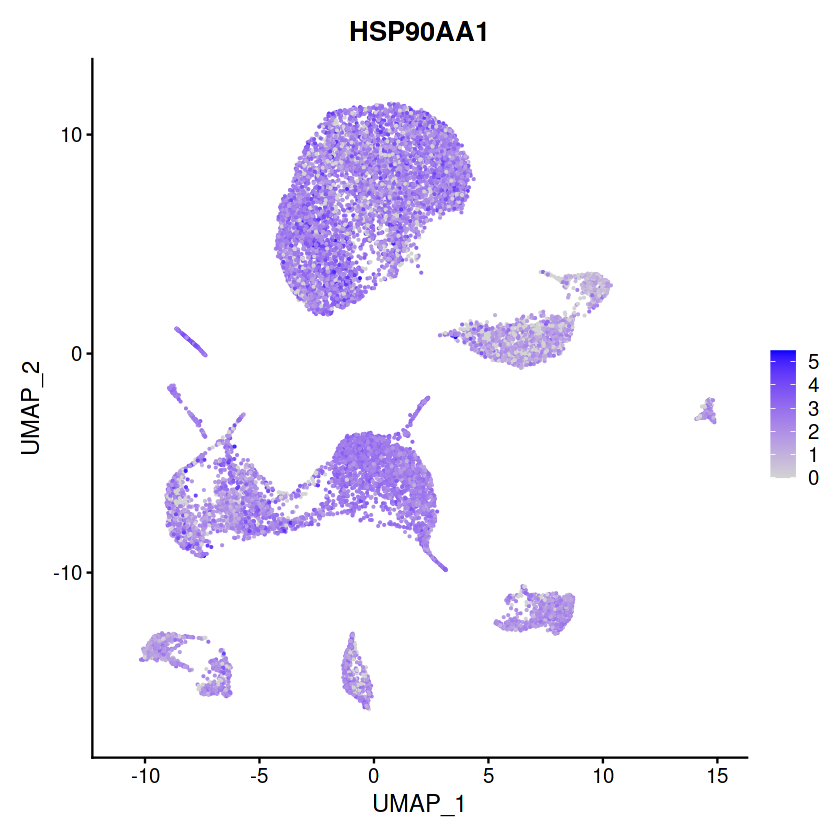

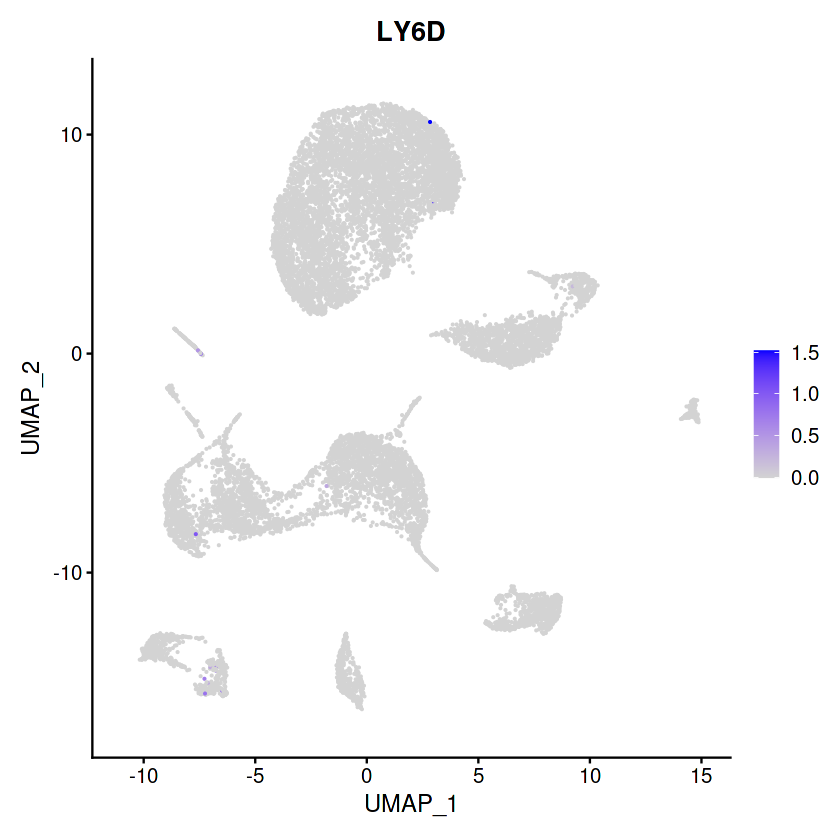

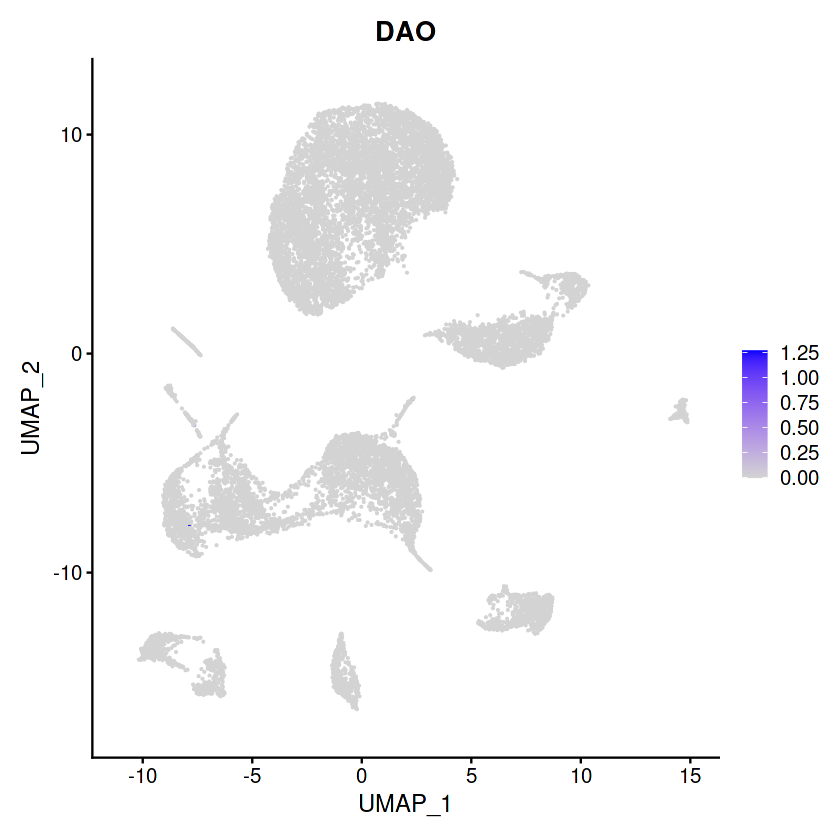

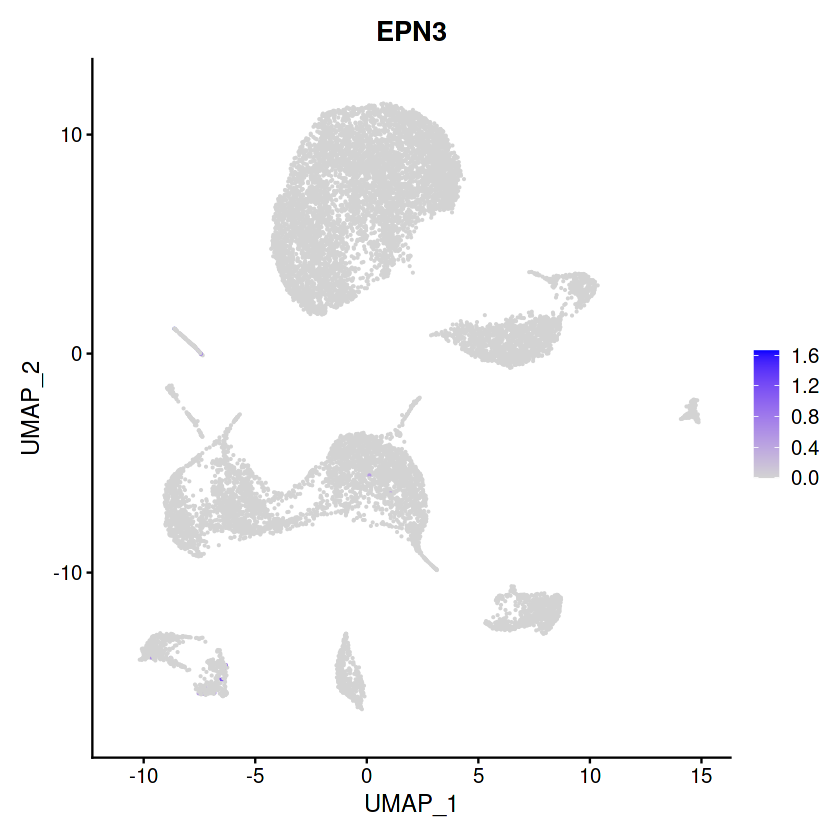

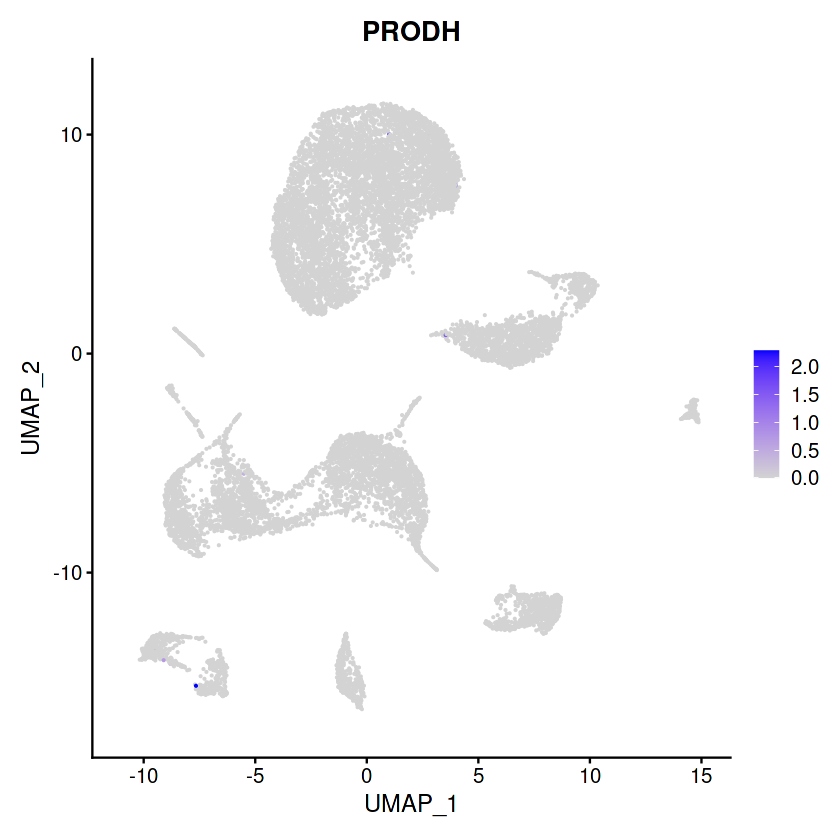

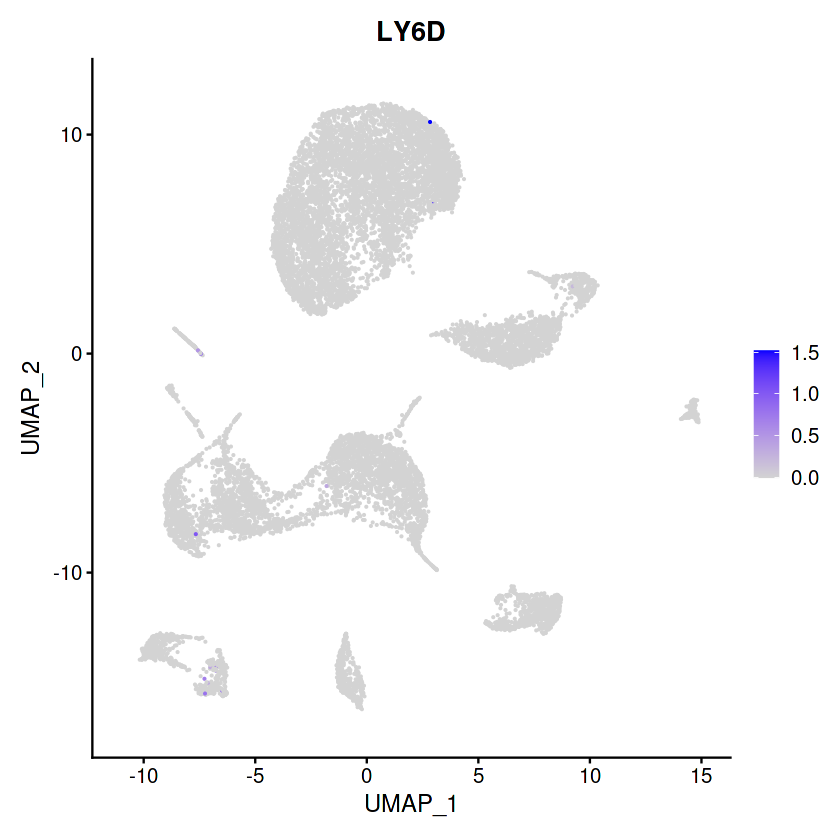

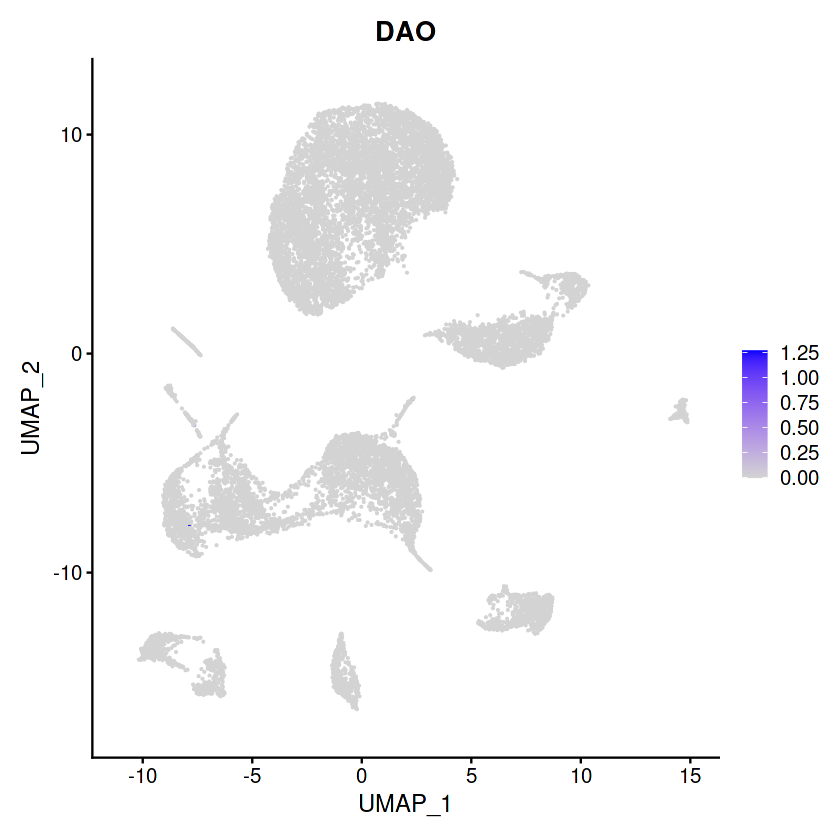

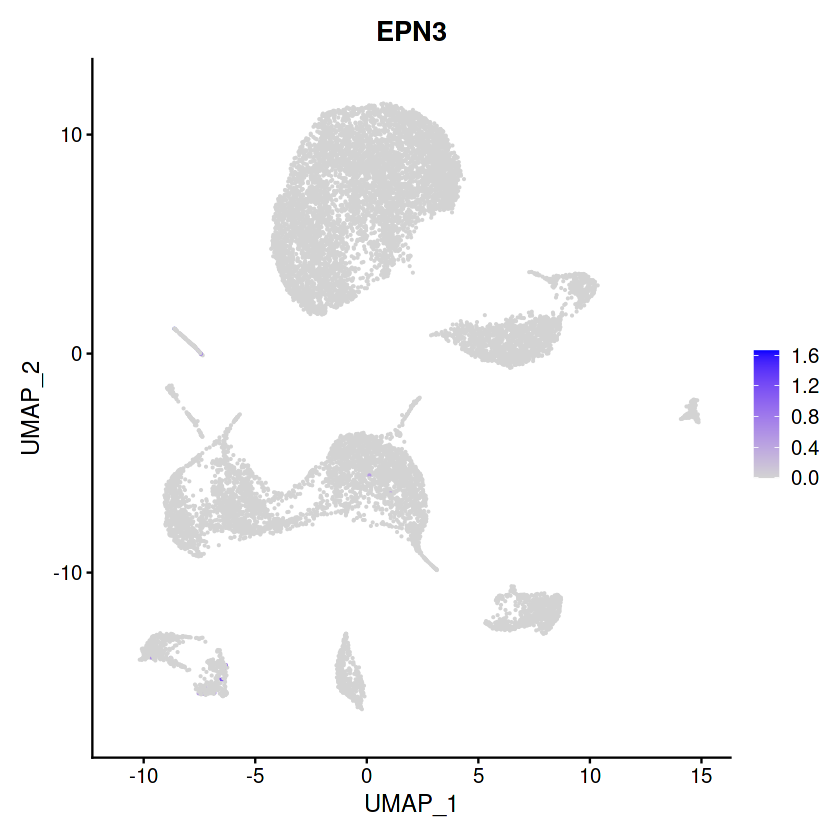

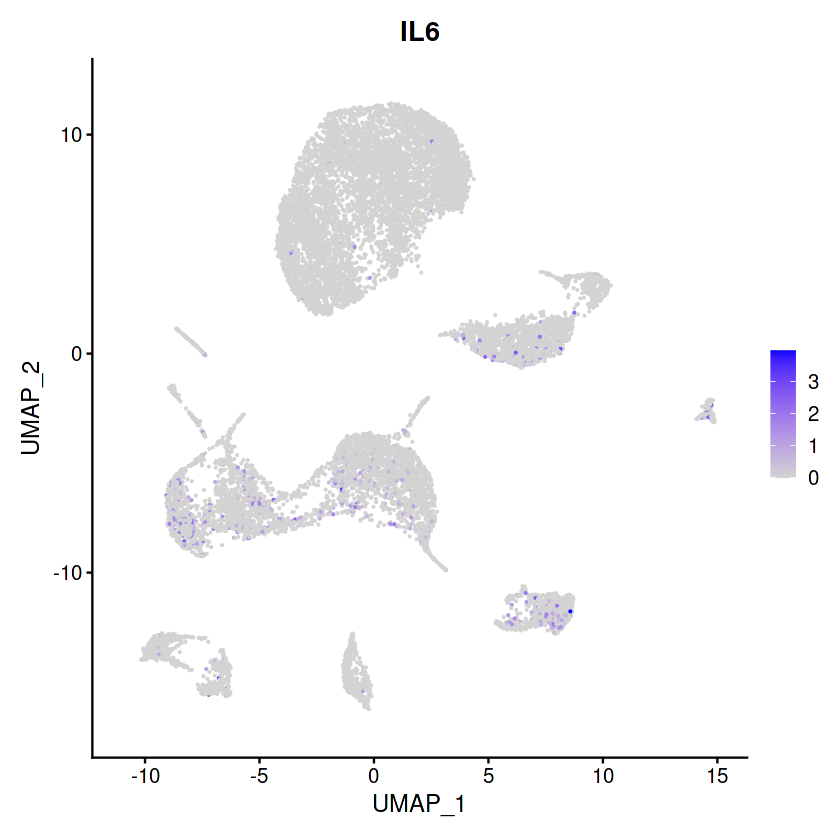

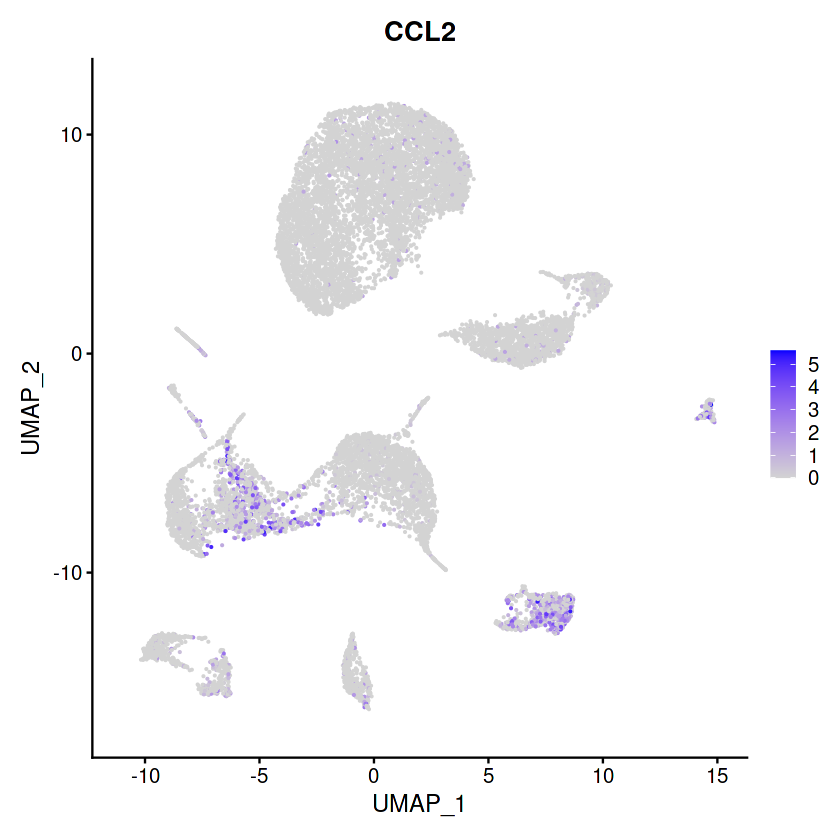

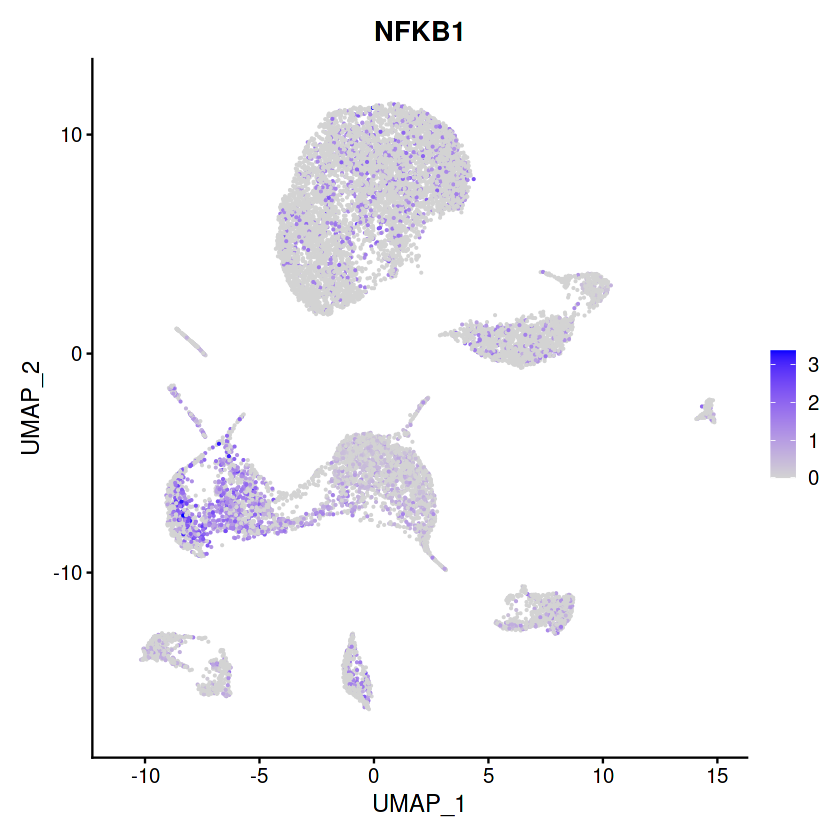

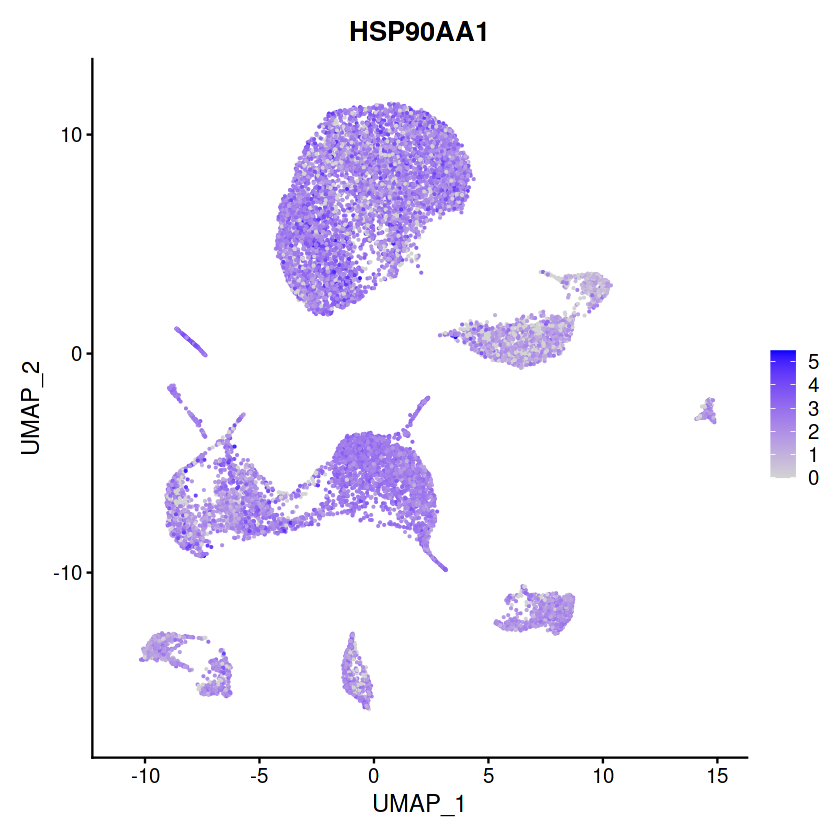

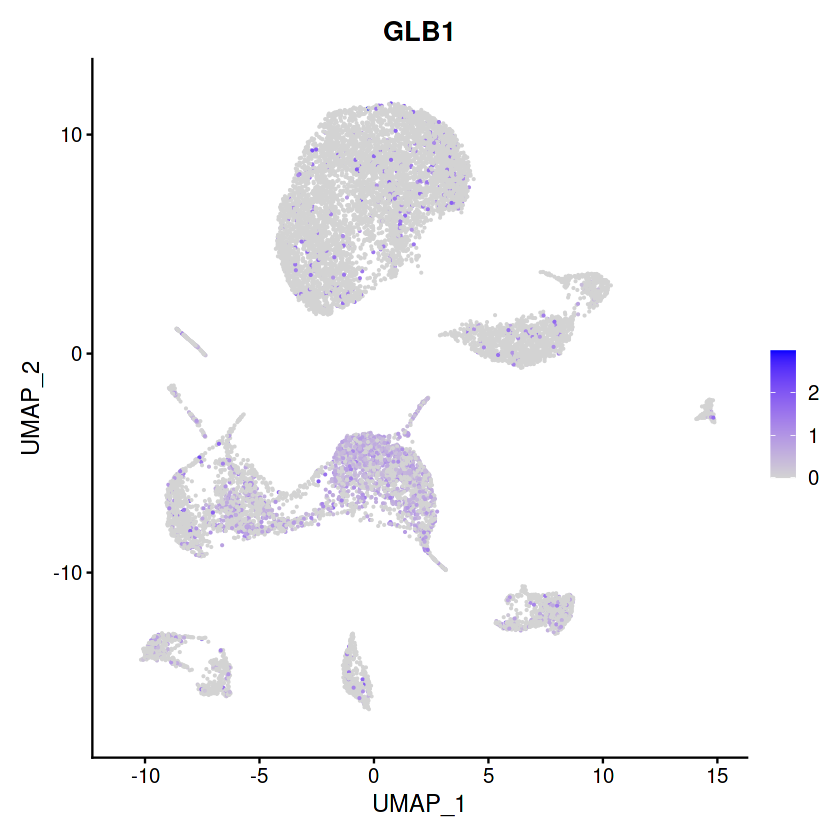

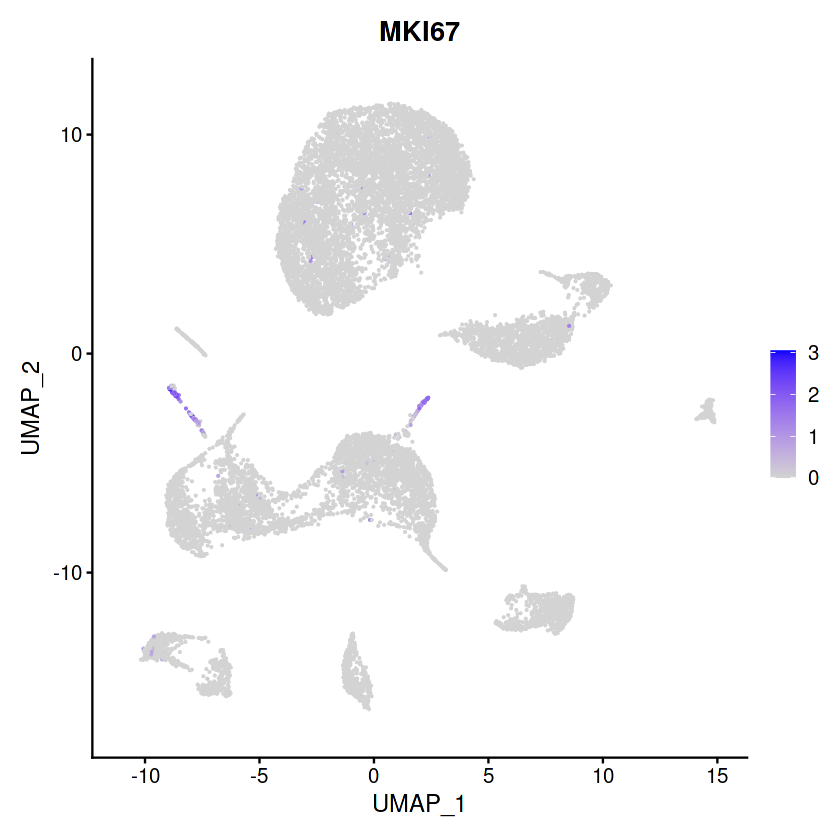

In [29]:
FeaturePlot(pbmcF, features = c("CDKN1A"))
FeaturePlot(pbmcF, features = c("CDKN2A"))
FeaturePlot(pbmcF, features = c("LMNB1"))
FeaturePlot(pbmcF, features = c("PRODH"))
FeaturePlot(pbmcF, features = c("TP53"))
FeaturePlot(pbmcF, features = c("MTOR"))
FeaturePlot(pbmcF, features = c("HSP90AA1"))
FeaturePlot(pbmcF, features = c("LY6D"))
FeaturePlot(pbmcF, features = c("DAO"))
FeaturePlot(pbmcF, features = c("EPN3"))
FeaturePlot(pbmcF, features = c("PRODH"))
FeaturePlot(pbmcF, features = c("LY6D"))
FeaturePlot(pbmcF, features = c("DAO"))
FeaturePlot(pbmcF, features = c("EPN3"))
FeaturePlot(pbmcF, features = c("IL6")) 
FeaturePlot(pbmcF, features = c("CCL2"))
FeaturePlot(pbmcF, features = c("NFKB1"))
FeaturePlot(pbmcF, features = c("HSP90AA1"))
FeaturePlot(pbmcF, features = c("GLB1"))
FeaturePlot(pbmcF, features = c("MKI67"))